# Zillow Home Value Prediction Project 
    Christopher Curran

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import env
import acquire
import wrangle
from scipy import stats
import sklearn.preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from numpy import percentile
import uszipcode
from uszipcode import SearchEngine


from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge, SGDRegressor, LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, make_scorer
from sklearn.pipeline import Pipeline, make_pipeline
from geopy.geocoders import Nominatim
import math

sns.set()

/opt/homebrew/Caskroom/miniforge/base/envs/codeup/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Project Overview:
    To create a dataset of Zillow data that can be used to predict the value of a home.

# Data Acquistion

In [2]:
# Load the data from acquire.py using get_zillow_data()
df = acquire.get_zillow_data()

Reading from csv file...


In [3]:
# Create deep copy of original df and reassign it to df_prep
df_prep = df.copy(deep=True)

# Prepare Data

In [4]:
train, validate, test = wrangle.wrangle_zillow(df_prep)

# EDA

/opt/homebrew/Caskroom/miniforge/base/envs/codeup/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'line_kws'
  cset = contour_func(
/opt/homebrew/Caskroom/miniforge/base/envs/codeup/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'line_kws'
  cset = contour_func(


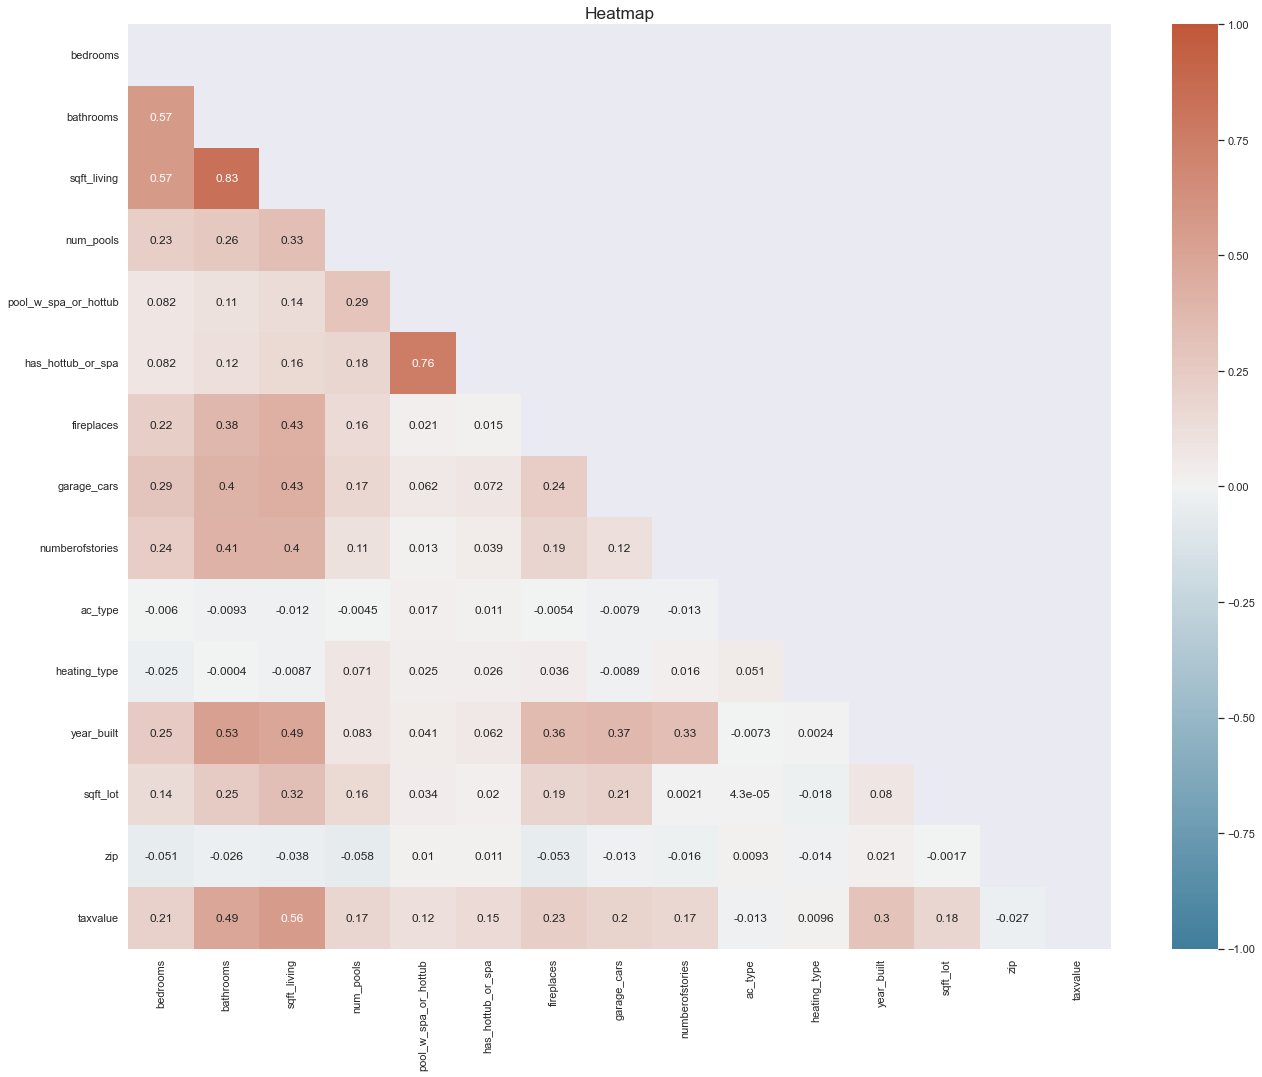

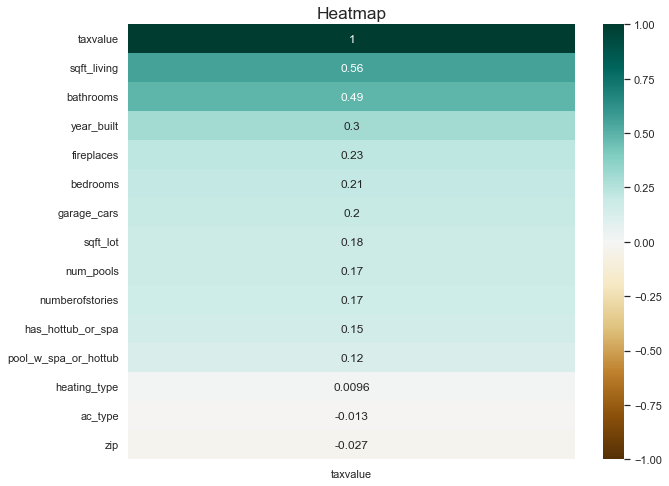

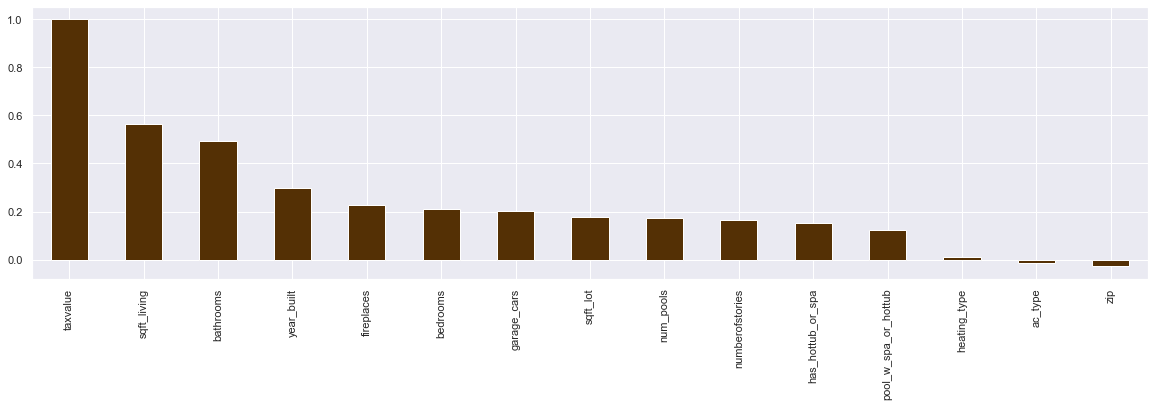

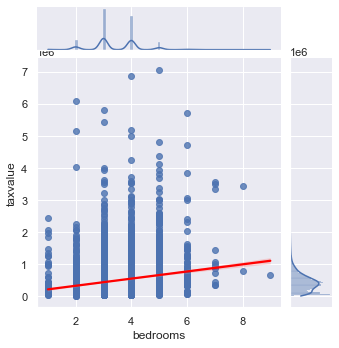

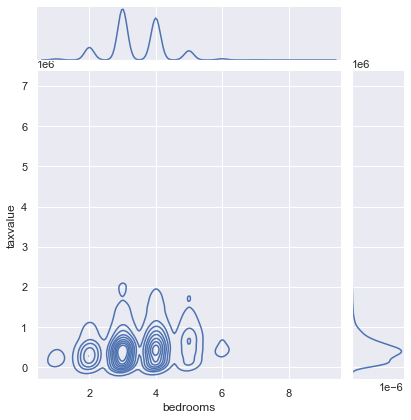

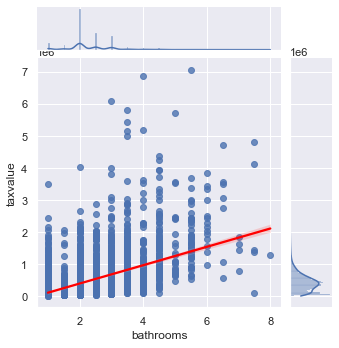

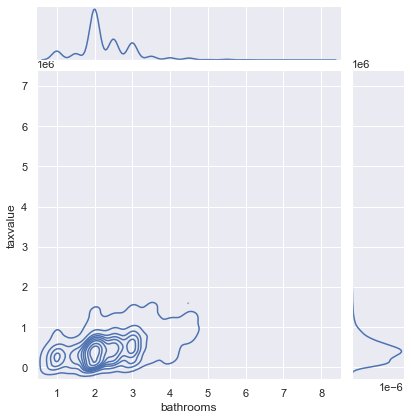

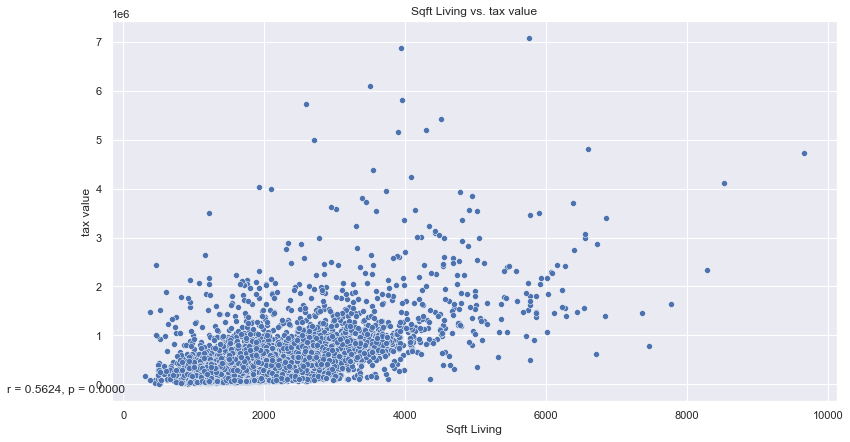

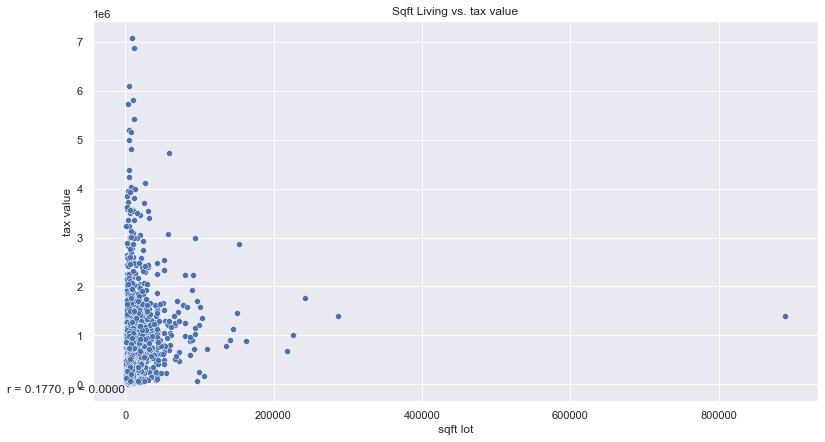

In [5]:
wrangle.corrstatsgraphs3(train)

In [6]:
train.head()

,bedrooms,bathrooms,sqft_living,num_pools,pool_w_spa_or_hottub,has_hottub_or_spa,fireplaces,garage_cars,numberofstories,ac_type,heating_type,year_built,sqft_lot,zip,county,taxvalue
1081,3.0,1.5,1289.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,2.0,1962.0,6000.0,96185.0,"Orange, CA",141623.0
610,3.0,2.0,1823.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1955.0,6600.0,97041.0,"Orange, CA",432903.0
2069,3.0,2.0,1041.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1957.0,5860.0,96186.0,"Orange, CA",371706.0
7016,3.0,3.5,3113.0,1.0,0.0,0.0,2.0,2.0,2.0,0.0,6.0,1976.0,15180.0,97005.0,"Orange, CA",870258.0
4871,2.0,1.0,899.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,1948.0,7048.0,96181.0,"Orange, CA",45883.0


In [33]:
def corrstatsgraphs3(df):
    """
    Description
    ----
    Outputs the general statistical description of the dataframe,
    outputs the correlation heatmap with target label, and outputs a distribution plot.
    
    Parameters
    ----
    df(DataFrame):
        The dataframe for which information will be displayed.
        
    Returns
    ----
    useful stats, correlation, and subplots
    
    """
       
    # Heatmap with min -1 to max 1 to all variables
    # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html
    corr = df.corr()
    plt.subplots(figsize=(22, 17))
    plt.title("Heatmap", fontsize = 'x-large')
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 21, as_cmap=True)
    sns.heatmap(corr, annot=True, mask = mask, cmap=cmap, vmin=-1, vmax=1
    )
    # Correlation Heatmap with min -1 to max 1 in conjuction with pd.corr 
    plt.figure(figsize=(10, 8)) 
    plt.title("Heatmap", fontsize = 'x-large')
    sns.heatmap(df.corr()[['taxvalue']].sort_values(by='taxvalue', 
    ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG'
    )
    # Correlation Heatmap with min -1 to max 1 in conjuction with pd.corr
    plt.figure(figsize=(16,10))
    df.corr()['taxvalue'].sort_values(ascending=False).plot(kind='bar', figsize=(20,5), cmap='BrBG'
    )
    
    fig, axes = plt.subplots(2,2)
    sns.jointplot(x="bedrooms", y="taxvalue", data=df,  kind='reg', height=5, line_kws={'color': 'red'}, ax=axes[0,0])
    
    sns.jointplot(x="bedrooms", y="taxvalue", data=df,  kind='kde', line_kws={'color': 'red'}, ax=axes[0,1])
    
    sns.jointplot(x="bathrooms", y="taxvalue", data=df, ratio=5, kind='reg', height=5, line_kws={'color': 'red'}, ax=axes[1,0])
    
    sns.jointplot(x="bathrooms", y="taxvalue", data=df,  kind='kde', line_kws={'color': 'red'}, ax=axes[1,1])
    
    fig, axes = plt.subplots(figsize=(13, 7))
    r, p = stats.pearsonr(df.sqft_living, df.taxvalue)
    sns.regplot(data=df, x=df.sqft_living, y=df.taxvalue,fit_reg=True, line_kws={'color': 'red'})
    axes.set(
    xlabel='Sqft Living',
    ylabel='tax value',
    title='Sqft Living vs. tax value',
    )
    text = f'r = {r:.4f}, p = {p:.4f}'
    axes.text(25, 120, text, va='top', ha='right'
    )
    fig, axes = plt.subplots(1,2,figsize=(13, 7))
    r, p = stats.pearsonr(df.sqft_lot, df.taxvalue)
    sns.regplot(data=df, x=df.sqft_lot, y=df.taxvalue,fit_reg=True, line_kws={'color': 'red'})
    axes.set(
    xlabel='sqft lot',
    ylabel='tax value',
    title='Sqft Living vs. tax value',
    )
    text = f'r = {r:.4f}, p = {p:.4f}'
    axes.text(25, 120, text, va='top', ha='right')
    plt.show()

    fig

/opt/homebrew/Caskroom/miniforge/base/envs/codeup/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'line_kws'
  cset = contour_func(
/opt/homebrew/Caskroom/miniforge/base/envs/codeup/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'line_kws'
  cset = contour_func(


AttributeError: 'numpy.ndarray' object has no attribute 'set'

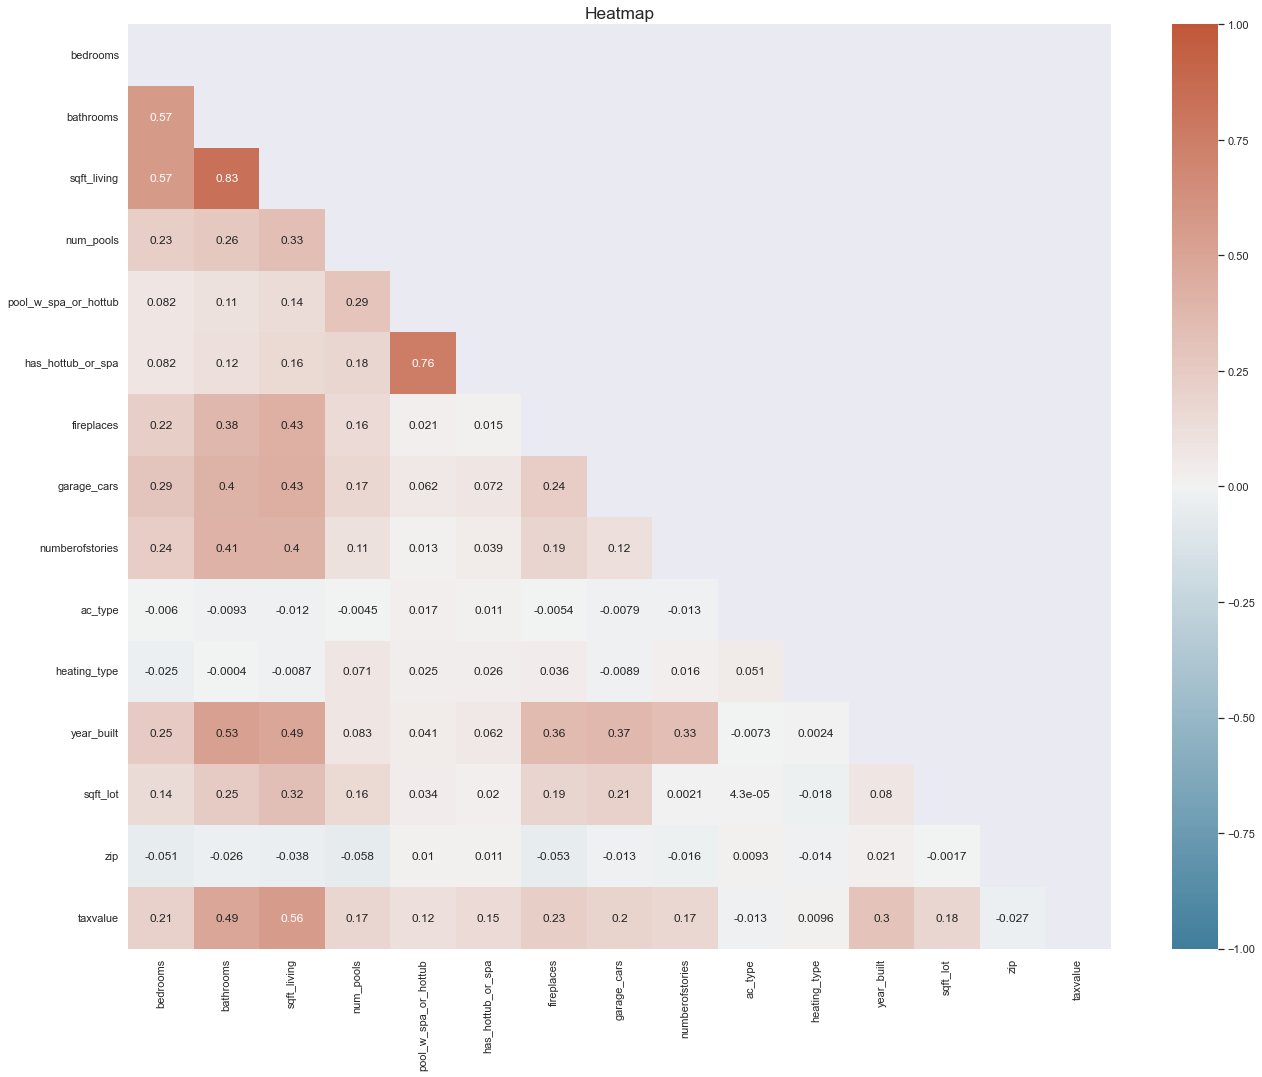

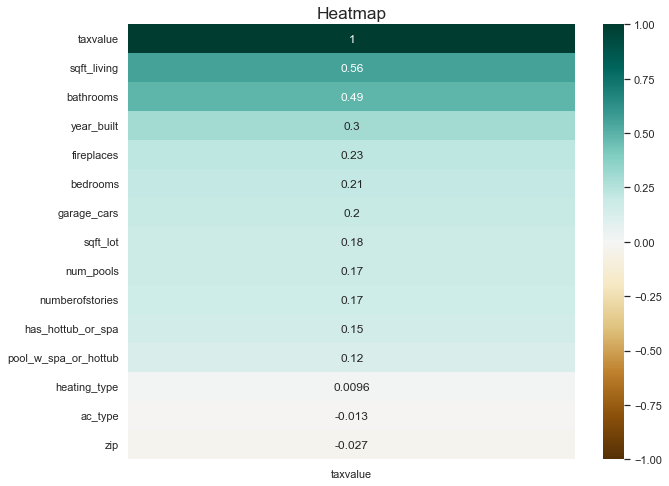

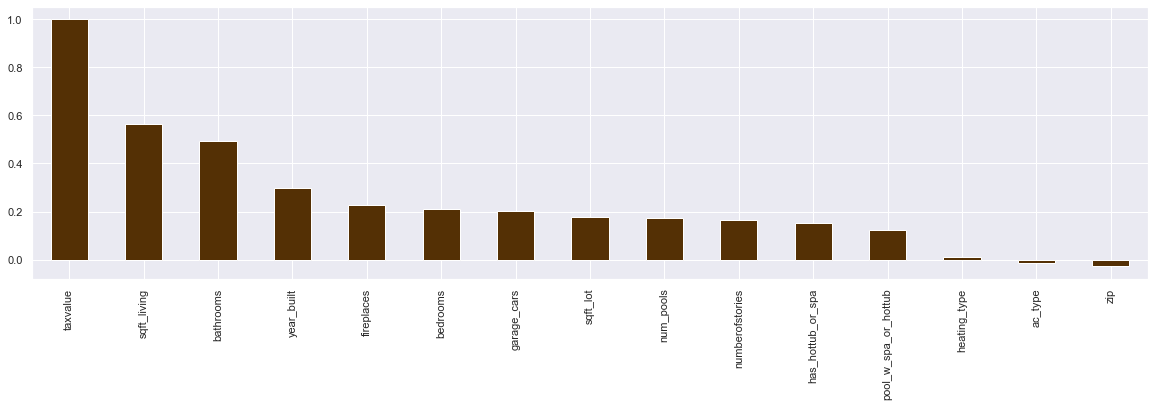

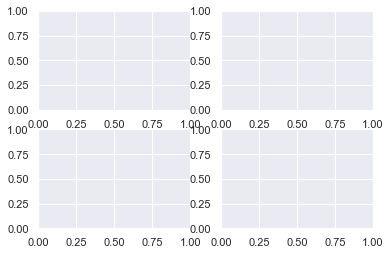

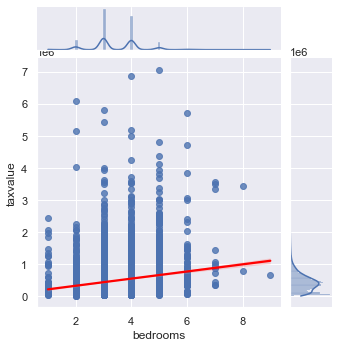

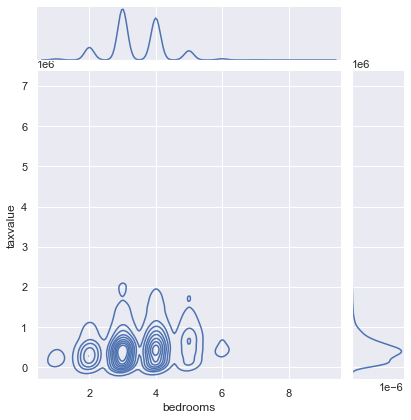

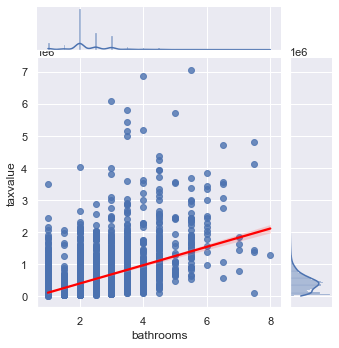

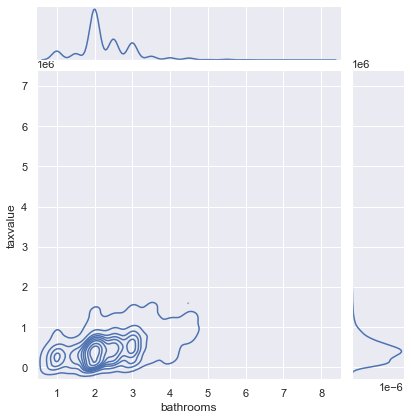

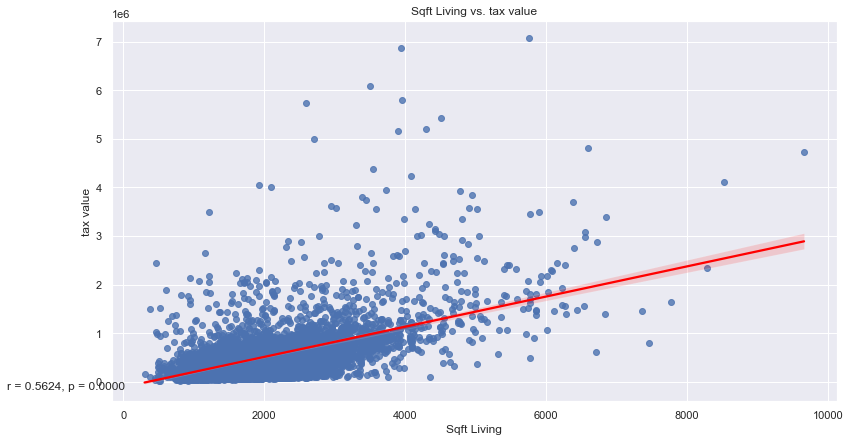

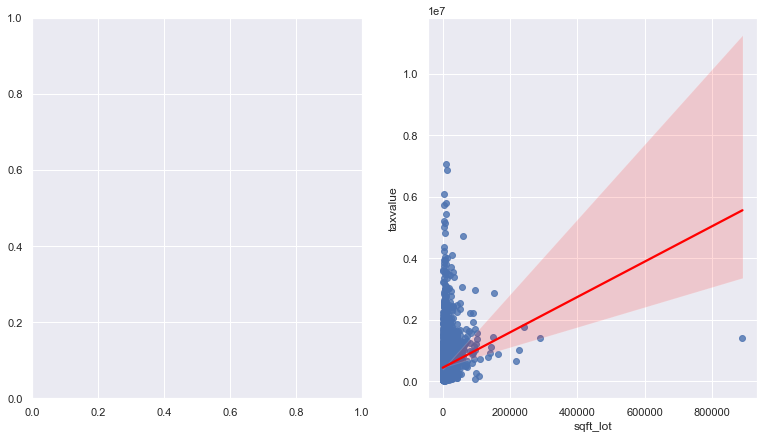

In [34]:
corrstatsgraphs3(train)